In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten 
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
if(os.path.isdir("data") == False):
    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)

In [6]:
import uuid 

In [7]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = cv2.flip(frame, 1)
#     frame = frame[230:230+250, 190:190+250, :]
    
#     cv2.imshow('Image Collection', frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('a'):
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)
#     if cv2.waitKey(1) & 0xFF == ord('p'):
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(120)
positive = tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(120)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(120)

In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
print(dir_test.next())

b'data\\anchor\\3645f183-6644-11ec-93f2-c0e434a81590.jpg'


In [11]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [12]:
img = preprocess('data\\anchor\\391f28da-6644-11ec-9c9f-c0e434a81590.jpg')

In [13]:
img.numpy().max()

0.8308824

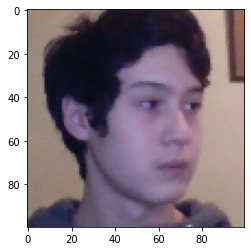

In [14]:
plt.imshow(img)

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len((anchor))))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len((anchor))))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
example = samples.next()

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [19]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [20]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [21]:
test_data = data.skip(round(len(data)*.7))
test_data = train_data.take(round(len(data)*.3))

In [22]:
### Model
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_img')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    #Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    #Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    #Fourth block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embeding')

In [23]:
embedding = make_embedding()

In [24]:
embedding.summary()

Model: "embeding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       262

In [25]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [26]:
def make_siemese_model():
    input_img = Input(name="input_img", shape=(100, 100, 3))
    
    validation_img = Input(name="validation_img", shape=(100, 100, 3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img), embedding(validation_img))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_img, validation_img], outputs=classifier, name='SiameseNetwork')

In [27]:
siamese_model = make_siemese_model()

In [28]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embeding (Functional)          (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [29]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [30]:
opt = tf.keras.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [32]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        
        x = batch[:2]
        y  = batch[2]
        
        yhat = siamese_model(x, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [33]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
    return

In [34]:
EPOCHS = 50

In [35]:
# train(train_data, EPOCHS)

In [36]:
from tensorflow.keras.metrics import Precision, Recall

In [37]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [38]:
test_var = test_data.as_numpy_iterator().next()

In [39]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[0.5000893 ],
       [0.50238574],
       [0.50153726],
       [0.5004693 ],
       [0.5047898 ],
       [0.5022395 ],
       [0.503205  ],
       [0.5019213 ],
       [0.5018814 ],
       [0.50017035],
       [0.5005306 ],
       [0.5003102 ],
       [0.50302345],
       [0.50131583],
       [0.50199664],
       [0.5011199 ]], dtype=float32)

In [40]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [41]:
y_true

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

In [42]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

0.375

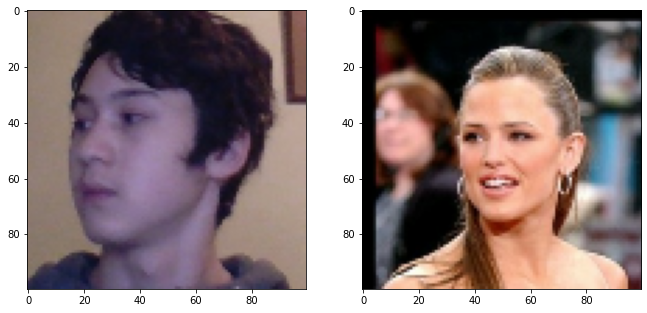

In [43]:
plt.figure(figsize=(11, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[6])
plt.subplot(1, 2, 2)
plt.imshow(test_val[6])
plt.show()

In [44]:
siamese_model.save('siamesemodel.h5')

In [64]:
abc_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [65]:
y1_hat = abc_model.predict([test_input, test_val])
y1_hat


array([[9.9997294e-01],
       [9.8552493e-07],
       [1.2331872e-08],
       [9.9918276e-01],
       [7.8180697e-09],
       [2.4129548e-07],
       [7.8944877e-06],
       [3.0428968e-08],
       [1.1399708e-07],
       [1.0000000e+00],
       [9.9999666e-01],
       [9.9989057e-01],
       [9.4304556e-07],
       [1.0000000e+00],
       [1.2299973e-08],
       [9.4352290e-06]], dtype=float32)

In [66]:
y_true

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

In [67]:
[1 if prediction > 0.5 else 0 for prediction in y1_hat]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]

In [68]:
m = Precision()
m.update_state(y_true, y1_hat)
m.result().numpy()

1.0

In [69]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold 
    
    return results, verified

In [70]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    frame = frame[230:230+250, 190:190+250, :]
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(abc_model, 0.5, 0.5)
        print(verified)
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False
True
False


In [71]:
results

[array([[0.99971783]], dtype=float32),
 array([[0.86402905]], dtype=float32),
 array([[0.99986184]], dtype=float32),
 array([[0.99989057]], dtype=float32),
 array([[0.01128253]], dtype=float32),
 array([[0.10412934]], dtype=float32),
 array([[0.9102268]], dtype=float32),
 array([[0.9404013]], dtype=float32),
 array([[0.45594358]], dtype=float32),
 array([[0.8475356]], dtype=float32),
 array([[0.9566294]], dtype=float32),
 array([[0.12424883]], dtype=float32),
 array([[0.34985027]], dtype=float32),
 array([[0.38411132]], dtype=float32),
 array([[4.933072e-05]], dtype=float32),
 array([[3.1326323e-05]], dtype=float32),
 array([[0.00122386]], dtype=float32),
 array([[0.00011352]], dtype=float32),
 array([[0.00020218]], dtype=float32),
 array([[6.2174244e-05]], dtype=float32),
 array([[5.4072243e-05]], dtype=float32),
 array([[0.00554535]], dtype=float32),
 array([[0.00023574]], dtype=float32),
 array([[0.9046242]], dtype=float32),
 array([[0.31319702]], dtype=float32),
 array([[0.11881271